# Deep Computer Vision Using Convolutional Neural Networks

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow import keras

# Set RNG state
np.random.seed(42)
tf.random.set_seed(42)


def plot_image(image):
    plt.imshow(image, cmap="gray", interpolation="nearest")
    plt.axis("off")

def plot_color_image(image):
    plt.imshow(image, interpolation="nearest")
    plt.axis("off")

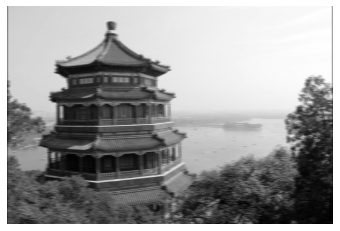

In [2]:
from sklearn.datasets import load_sample_image

max_intensity = 255

# Load sample images
china = load_sample_image("china.jpg") / max_intensity
flower = load_sample_image("flower.jpg") / max_intensity
images = np.array([china, flower])

batch_size, height, width, channels = images.shape

# Create 2 filters
filters = np.zeros(shape=(7, 7, channels, 2), dtype=np.float32)
filters[:, 3, :, 0] = 1  # vertical line
filters[3, :, :, 1] = 1  # horizontal line

# Compute 2D convolution of two images and two filters (conv. kernels)
outputs = tf.nn.conv2d(images, filters, strides=1, padding="SAME")

# Plot 1st image's 2nd feature map
plt.imshow(outputs[0, :, :, 1], cmap="gray")
plt.axis("off")
plt.show()

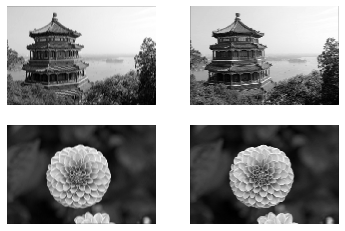

In [3]:
for image_index in (0, 1):
    for feature_map_index in (0, 1):
        plt.subplot(2, 2, image_index * 2 + feature_map_index + 1)
        plot_image(outputs[image_index, :, :, feature_map_index])

plt.show()

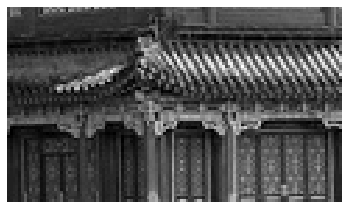

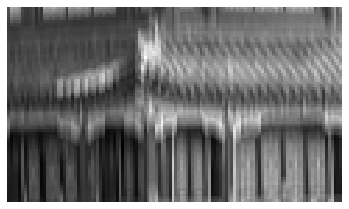

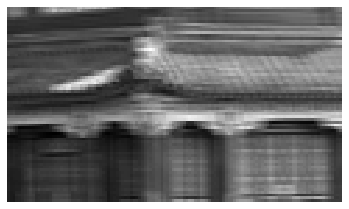

In [4]:
def crop(images):
    return images[150:220, 130:250]

# Plot cropped original images
plot_image(crop(images[0, :, :, 0]))
plt.show()

# Plot cropped feature maps
for feature_map_index in (0, 1):
    plot_image(crop(outputs[0, :, :, feature_map_index]))
    plt.show()

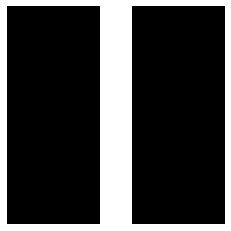

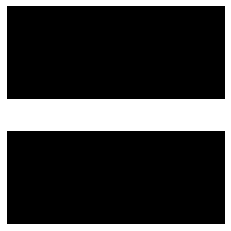

In [5]:
# Plot 1st filter
plot_image(filters[:, :, 0, 0])
plt.show()

# Plot 2nd filter
plot_image(filters[:, :, 0, 1])
plt.show()

## Convolutional Layer

Output of a neuron in a convolutional layer is at pixels $i, j$ in feature map $k$:
$z_{i,j,k} = b_k + \sum_{u = 0}^{f_h - 1} \sum_{v = 0}^{f_w - 1} \sum_{k' = 0}^{f_{n'} - 1} x_{i',j',k'} \times w_{u,v,k',k}$
where
* $f_h, f_w$ are the height and width of the *receptive field*, $f_{n'}$ is the number of feature maps in a conv. layer (no. conv. kernels or filters)
* $i' = i \times s_h + u$ and $j' = j \times s_w + v$ ($s_h$ and $s_w$ is are the vertical and horizontal *stride* hyper-parameters)
* $x_{i',j',k'}$ is the output of a neuron in previous (or input) layer at location $i', j'$ and in feature map $k'$
* $b_k$ is the bias term of feature map $k$ which tweaks the overall brightness of this feature map
* $w_{u,v,k',k}$ is the weight between a neuron in feature map $k$ and neuron in previous layer at respective location $u,v,k'$

*TensorFlow* typically represents an input image as a 3D tensor of shape *[height, width, channels]* and a micro-batch then is a 4D tensor with shape *[batch size, height, width, channels]*. The weights of a convolutional layer are also 4D tensors of shape $[f_h, f_w, f_{n'}, f_n]$.

In [6]:
# Build a 2D convolutional layer with 32 feature maps, kernels of size 3, no stride and ReLU activation
#  - `padding="SAME"` means that we add artificial 0 around the input to fill up the kernel at boarder locations
#  - `padding="VALID"` would skip some rows and/or coluns so that the kernel (filter) always points to valid image locations
conv = keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="SAME", activation="relu")

## Pooling layer

### Max pooling
*Max pooling* layer serves to subsample the inputs. It's similart to a conv. layer as it also contains a sliding kernel but contrary to convolutional layer it has no weights. So it is effectively a stateless transformation that reduces the number of parameters to train, adds some translational invariance and helps the model to focuse on the most intensive signals during training.

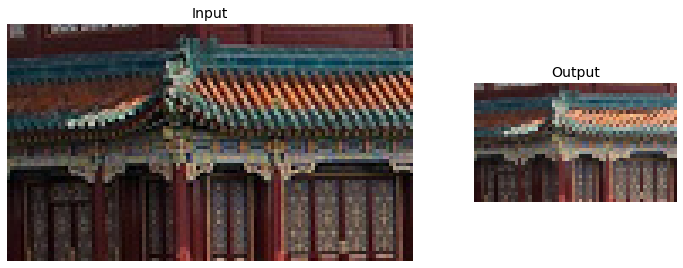

In [7]:
import matplotlib as mpl

# Crop each input image
cropped_images = np.array([crop(image) for image in images], dtype=np.float32)

# Create and apply a max pooling layer with 2x2 kernel and stride 2
max_pool = keras.layers.MaxPool2D(pool_size=2)
output = max_pool(cropped_images)

# Plot the input and max pooling output of the 1st image
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

# Cropped input image
ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

# Max pooled output
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output[0])
ax2.axis("off")

plt.show()

### Depth-wise pooling
It is also possible to pool not across the feature map dimension. This way one can make the model invariant to particular patterns, colors, transformations, etc. There is no TF/Keras high-level class but using a low-level API it's easy to implement.

In [8]:
class DepthMaxPool(keras.layers.Layer):
    
    def __init__(self, pool_size, strides=None, padding="VALID", **kwargs):
        super().__init__(**kwargs)
        if strides is None:
            strides = pool_size
        self.pool_size = pool_size
        self.strides = strides
        self.padding = padding
    
    def call(self, inputs):
        # Apply the max pooling to depth
        #  - note that `pool_size` must be a multiple of the number of feature maps
        return tf.nn.max_pool(
            inputs,
            ksize=(1, 1, 1, self.pool_size),
            strides=(1, 1, 1, self.pool_size),
            padding=self.padding,
        )

# Test the depth max pooling on our cropped images
depth_pool = DepthMaxPool(3)

with tf.device("/cpu:0"):
    depth_output = depth_pool(cropped_images)

depth_output.shape

TensorShape([2, 70, 120, 1])

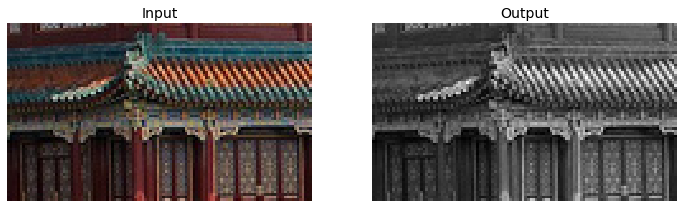

In [9]:
plt.figure(figsize=(12, 8))

# Plot the 1st image
plt.subplot(1, 2, 1)
plt.title("Input", fontsize=14)
plot_color_image(cropped_images[0])

# Plot the output for the 1st image
plt.subplot(1, 2, 2)
plt.title("Output", fontsize=14)
plot_image(depth_output[0, ..., 0])
plt.axis("off")

plt.show()

### Average pooling
Average pooling just uses different aggregation function (average instead of max) but otherwise it's pretty much the same.

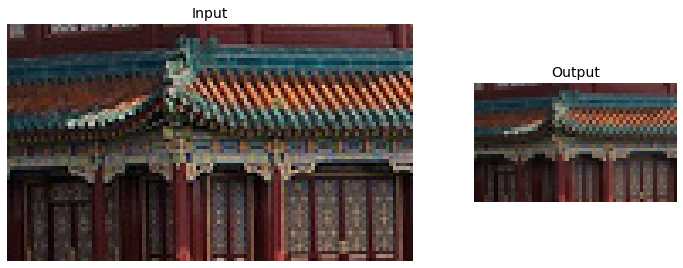

In [10]:
avg_pool = keras.layers.AvgPool2D(pool_size=2)
output_avg = avg_pool(cropped_images)

fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input", fontsize=14)
ax1.imshow(cropped_images[0])
ax1.axis("off")

ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output", fontsize=14)
ax2.imshow(output_avg[0])
ax2.axis("off")

plt.show()

### Global Average Pooling
Global average pooling is different in that it applies the average to the whole feature map. In other words, it's like using kernel of the same size as the input.

It's implementation is equivalent to this lambda:
```python
output_global_avg = keras.layers.Lambda(lambda X: tf.reduce_mean(X, axis=[1, 2]))
output_global_avg(cropped_images)
```

In [11]:
global_avg_pool = keras.layers.GlobalAvgPool2D()
global_avg_pool(cropped_images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.2788801 , 0.22507527, 0.20967631],
       [0.51287866, 0.4595188 , 0.3342377 ]], dtype=float32)>